# <span style='color:blue;'>Objective of the Notebook</span>

## <span style='color:blue;'>Train a ANN on the clean ASL data</span>

## Steps used to achieve it
1. Take clean ASL images and Make agumented images for it.
2. Compute the hand landmark vector from this
3. Train a ANN based on the landmarks

Assumption: Actual ASL signs in train data can be filtered out using ANN trained on a clean ASL data

# The clean ASL data

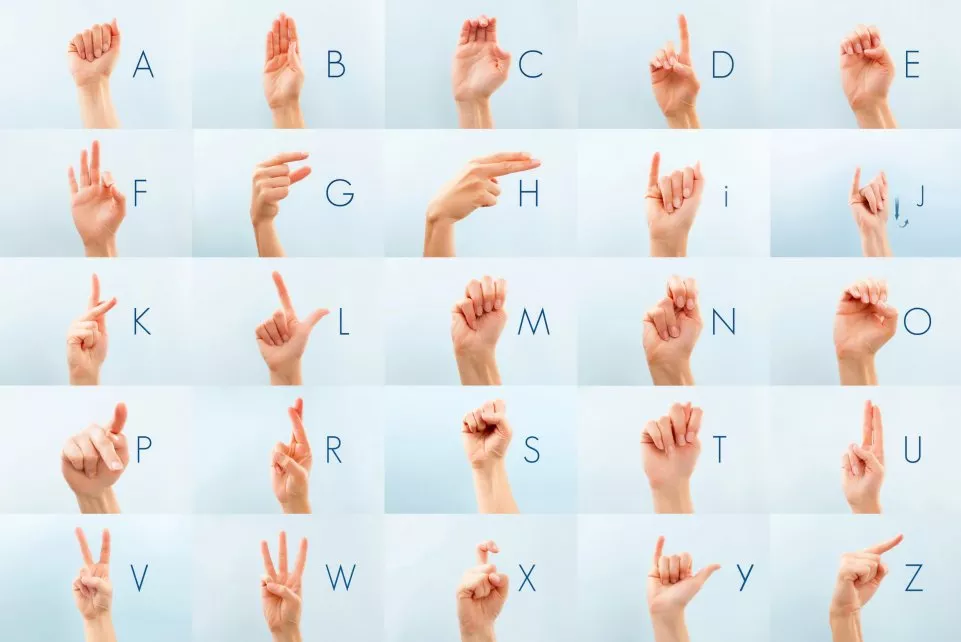

### > from this separate images of each character is extracted
### > I have used Agumentation to expand the ASL image data

### There are several types of image augmentations that can be performed on images, some of the commonly used ones are:
1. **Flipping** - flipping the image horizontally or vertically. - only vertical filp (but don't know if is ok with ASL)
2. **Rotation** - rotating the image by a certain degree angle. YES
3. **Scaling** - changing the size of the image by scaling up or down. -YES
4. **Translation** - shifting the image along the x and y-axis. -YES
5. **Cropping** - cropping a part of the image to create a new image. -NO don't serve purpose and should not make any change in MEDIAPIPE output
6. **Color jittering** - changing the brightness, contrast, and saturation of the image. -> should not make any change in MEDIAPIPE output
7. **Adding noise** - random noise to the image, which can help in making the model more robust to noisy data.
8. **Shearing** - distorting the image by shifting its pixels along a given angle.
9. **Elastic distortion** - applying a non-linear deformation to the image.
10. **Perspective transformation** - applying a perspective transformation to the image to create a new viewpoint.


### Selected augmentations (6 out of 10): Which produce different mediapipe cordinates
2. Rotation 
3. Scaling
4. Translation
8. Shearing
9. Elastic distortion
10. Perspective transformation

## The agumented images of clean ASL data is provided

API command: dataset datasets download -d gyannirohitsinghal/clean-asl-data

/dataset/input/asl-fingerspelling

In [9]:
# Showing all the directory names
new_folder='/dataset/input/clean-asl-data/'
for dirname, _, filenames in os.walk(new_folder):
    print(dirname)

/dataset/input/clean-asl-data/
/dataset/input/clean-asl-data/asl_alphabet_imgs
/dataset/input/clean-asl-data/asl_alphabet_imgs/N
/dataset/input/clean-asl-data/asl_alphabet_imgs/R
/dataset/input/clean-asl-data/asl_alphabet_imgs/B
/dataset/input/clean-asl-data/asl_alphabet_imgs/I
/dataset/input/clean-asl-data/asl_alphabet_imgs/F
/dataset/input/clean-asl-data/asl_alphabet_imgs/H
/dataset/input/clean-asl-data/asl_alphabet_imgs/E
/dataset/input/clean-asl-data/asl_alphabet_imgs/U
/dataset/input/clean-asl-data/asl_alphabet_imgs/M
/dataset/input/clean-asl-data/asl_alphabet_imgs/X
/dataset/input/clean-asl-data/asl_alphabet_imgs/K
/dataset/input/clean-asl-data/asl_alphabet_imgs/Y
/dataset/input/clean-asl-data/asl_alphabet_imgs/S
/dataset/input/clean-asl-data/asl_alphabet_imgs/G
/dataset/input/clean-asl-data/asl_alphabet_imgs/A
/dataset/input/clean-asl-data/asl_alphabet_imgs/O
/dataset/input/clean-asl-data/asl_alphabet_imgs/T
/dataset/input/clean-asl-data/asl_alphabet_imgs/V
/dataset/input/clean-

# PLEASE UPVOTE: HELPS N ENCOURANGE ME

## Below
### 1. take images and convert it to the vector
### 2. Use the vector to train a ANN 

Next: Try this to find the characters of ASL symbol in data "/dataset/input/asl-fingerspelling/train_landmarks"

In [2]:
# Install mediapipe 
!pip install mediapipe

In [18]:
# import all the requirments
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
from IPython.display import Image
import string
import albumentations as Alb
import matplotlib.pyplot as plt
import mediapipe as mp
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore", message="The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.", category=FutureWarning)

## A function is used to extract hand landmark data given as:

![](https://camo.githubusercontent.com/b0f077393b25552492ef5dd7cd9fd13f386e8bb480fa4ed94ce42ede812066a1/68747470733a2f2f6d65646961706970652e6465762f696d616765732f6d6f62696c652f68616e645f6c616e646d61726b732e706e67)

In [12]:
"""
Function get_landmark_vector: 
Input: the ASL image
Output:left and right hand's landmarks vector
vector indexs 
0-20: left hand x corrdiante
21-41: right hand x corrdiante
42-62: left hand y corrdiante
63-83: right hand y corrdiante
84-104: left hand z corrdiante
105-125: right hand z corrdiante
"""
def get_landmark_vector(image):
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_hands = mp.solutions.hands
    image_height, image_width, _ = image.shape
    annotated_image = image.copy()
    with mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=2,
        min_detection_confidence=0.5) as hands:
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    try:
        which_hand=results.multi_handedness[0].classification[0].label
    except:
        return None
    
    both_hands_vec = np.full((126,), np.nan)
    hand_landmark_list_x=[]
    hand_landmark_list_y=[]
    hand_landmark_list_z=[]
    for hand_landmarks in results.multi_hand_landmarks:
        for i in range(len(hand_landmarks.landmark)):
            hand_landmark_list_x.append(round(hand_landmarks.landmark[i].x, 4))
            hand_landmark_list_y.append(round(hand_landmarks.landmark[i].y, 4))
            hand_landmark_list_z.append(round(hand_landmarks.landmark[i].z, 4))
    if which_hand=='Right':
        try:
            both_hands_vec[21:42] = hand_landmark_list_x
            both_hands_vec[63:84] = hand_landmark_list_y
            both_hands_vec[105:126] = hand_landmark_list_x
        except:
            return None
    elif which_hand=='Left':
        try:    
            both_hands_vec[0:21] = hand_landmark_list_x
            both_hands_vec[42:63] = hand_landmark_list_y
            both_hands_vec[84:105] = hand_landmark_list_x
        except:
            return None        
    return both_hands_vec

In [13]:
# path of images after adding the dataset (please check the path in your case)
new_folder='/dataset/input/clean-asl-data/asl_alphabet_imgs'

In [16]:
# getting all the file names
img_file_name=pd.DataFrame(columns=['Name'])
count=0
for dirname, _, filenames in os.walk(new_folder):
    for filename in filenames:
        img_file=os.path.join(dirname, filename)
        img_file_name.loc[count,:]=img_file
        count+=1
print('Total number of images ', len(img_file_name))
print(img_file_name.head(5))

Total number of images  8000
                                                Name
0  /dataset/input/clean-asl-data/asl_alphabet_imgs...
1  /dataset/input/clean-asl-data/asl_alphabet_imgs...
2  /dataset/input/clean-asl-data/asl_alphabet_imgs...
3  /dataset/input/clean-asl-data/asl_alphabet_imgs...
4  /dataset/input/clean-asl-data/asl_alphabet_imgs...


In [20]:
# creating a df with 126 columns to save hand landmarks
clean_asl_df = pd.DataFrame(columns=[f'col_{i}' for i in range(126)])
char=pd.DataFrame(columns=['alphabet'])

In [23]:
count=0
for index in range(count,len(img_file_name)):
    Image=cv2.imread(img_file_name.loc[index,'Name'])
    vec=get_landmark_vector(Image)
    if vec is not None:
        clean_asl_df.loc[count,:]=vec
        char.loc[count,:]=img_file_name.loc[index,'Name'][-5]
        count+=1

In [24]:
# join landmarks of hand and alphabets 
join_df=pd.concat([clean_asl_df, char], axis=1)
join_df.to_csv('/dataset/working/hand_landmark_n_alphabet.csv', index=False)
join_df

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_117,col_118,col_119,col_120,col_121,col_122,col_123,col_124,col_125,alphabet
0,0.6409,0.7217,0.7676,0.7424,0.6953,0.7192,0.7253,0.7418,0.7443,0.6623,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,0.4717,0.5616,0.6071,0.5775,0.5248,0.5513,0.5537,0.5705,0.5731,0.4876,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.4798,0.5675,0.55,0.5244,0.5133,0.6293,0.5963,0.569,0.556,N
3,0.3912,0.4651,0.494,0.4492,0.3942,0.4363,0.4248,0.4479,0.4619,0.3796,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.4631,0.5395,0.5283,0.4989,0.4819,0.5931,0.5684,0.5376,0.518,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.5514,0.5829,0.6176,0.6332,0.6442,0.6224,0.6366,0.6219,0.6058,W
7206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.5599,0.5906,0.6285,0.6477,0.6612,0.6324,0.648,0.6306,0.6106,W
7207,0.4569,0.5089,0.5222,0.4521,0.3862,0.5205,0.547,0.561,0.57,0.4595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W
7208,0.47,0.5125,0.5144,0.4462,0.3843,0.5086,0.5225,0.5301,0.5333,0.4516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W


# PLEASE UPVOTE: HELPS N ENCOURANGE ME

REMAINING
### 2. Use the vector to train a ANN 